In [1]:
from main import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%%time 
#Fitting for Model 1: (without CD) #using curve_fit
fit = Fitting('KMC_NonDynamic_Data_iCovg_iRates.csv','Atomic.csv','Stoich.csv','Param.csv',Input_Type='iCovg_iRates') #covgdep = Allowing for coverage dependance to be considered in the fit
fit.set_rxnconditions() #Sets the Pressures and Temperature as defined from the Param file. (Note: One can also enter them manually - See main.py for syntax)
fit.set_limits_of_integration(fit.Input.iloc[0,0],fit.Input.iloc[-1,0])
fit.n_extract = 0.5

Mass is conserved. 

CPU times: user 20.5 ms, sys: 1.46 ms, total: 21.9 ms
Wall time: 21.7 ms


<IPython.core.display.Javascript object>


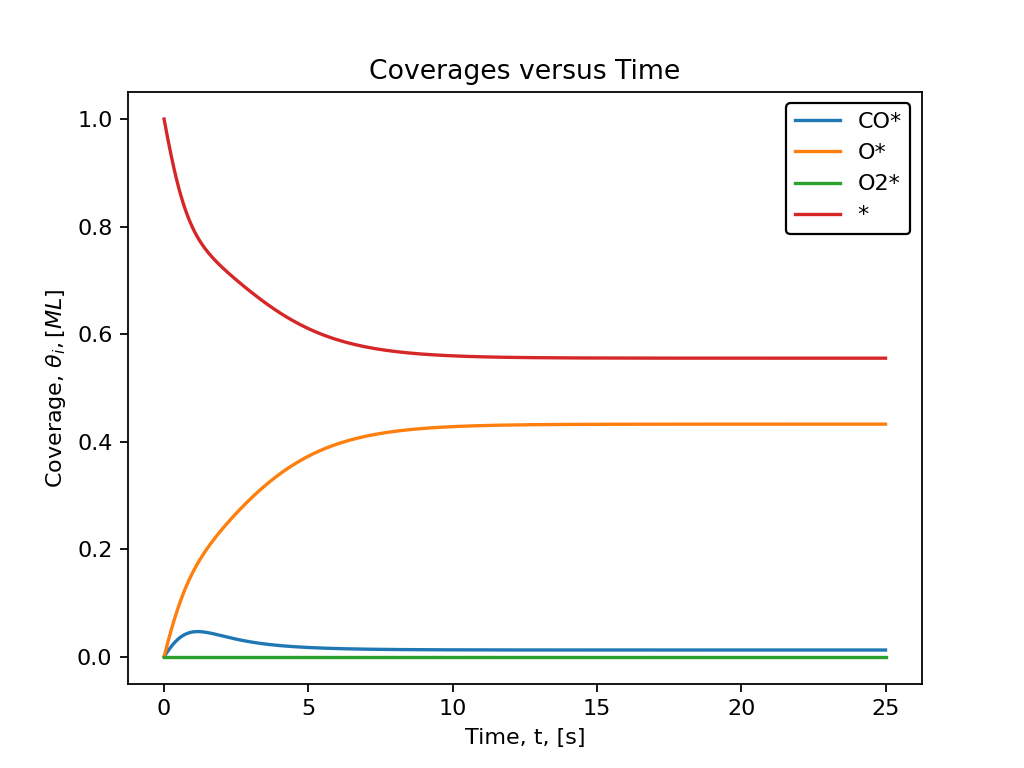

In [3]:
kfit1 = np.array([5.62922229e+06, 1.44144197e-08, 9.27331465e+06, 9.72747900e+03,
 4.23124465e+07, 4.62865632e+02, 7.34083737e+00, 2.56395440e+06])
fit.MKM.k = kfit1
sola1,solta1= fit.MKM.solve_coverage(plot=True) #Obtains the coverages(sol) with respect to time(solt) and plots them if plot=True (Note: Additional options can be set manually - See main.py for syntax)

In [4]:
fit.MKM.k

array([5.62922229e+06, 1.44144197e-08, 9.27331465e+06, 9.72747900e+03,
       4.23124465e+07, 4.62865632e+02, 7.34083737e+00, 2.56395440e+06])

In [5]:
a = fit.MKM.get_SS_rates_production()[:len(fit.MKM.Pextract())]

In [6]:
print(a)

[-0.03125226 -0.01562655  0.03125231]


In [7]:
actual = np.array([-0.025828993055555468, -0.034275173611110994, 0.033962673611110994])

In [8]:
#Calculating %difference
pd = np.empty(len(a))
for i in np.arange(len(a)):
    pd[i] = np.abs((actual[i]-a[i])/(actual[i]))*100

In [9]:
print(pd)

[20.99680304 54.4085459   7.98042785]
